# Notebook for ergodic attacks on linear systems

**Required dependencies**

* Python >= 3.5
* NumPy
* Scipy
* Matplotlib
* Cvxpy

In [300]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_lyapunov, solve_discrete_are, logm
from utils import System, dlqr, compute_power_series, compute_R, simulate, \
    compute_beta_theta, compute_beta_R, compute_I, compute_attack, \
    compute_ergodic_reward



In [301]:
## Setup plot parameters
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "legend.fontsize": 14,
    })

plt.rcParams['pgf.preamble'] = r"\usepackage{units} \usepackage{amsmath} \usepackage{metalogo} \usepackage{unicode-math} \setmainfont{DejaVu Serif} \setmathfont{xits-math.otf}"
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsfonts}'
})
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## System definition
Initialization of the system

In [302]:
# System definition
A = np.matrix([[0.7, 0.9],[1.5, 2.]])
B = np.matrix([[0, 2],[4, 2]])
n, m = B.shape
I = np.matrix(np.identity(n))

# Feedback gain
K = -0.95*dlqr(A, B, I, 0 * I)

Q = np.matrix(I)
Qinv = np.linalg.inv(Q)

original_system = System(A, B, K, 0 * K, 0 * I, np.zeros(m), Q)
L = A + B @ K

print('K: {}'.format(K))
print('Eigenvalues closed loop system: {}'.format(np.linalg.eig(L)[0]))

K: [[-0.19    -0.26125]
 [-0.3325  -0.4275 ]]
Eigenvalues closed loop system: [0.00093237 0.13406763]


## Helper functions

In [294]:
def compute_attack(sys, beta):
    # Computes the optimal Gaussian attack. Returns \bar{K} and the covariance noise of the attack
    P, F, _, _, _ = compute_P(sys, beta)
    L = sys.A + sys.B @ sys.K
    
    Binv = np.linalg.inv(sys.B.T @ sys.B) @ sys.B.T
    Kbar = beta * Binv @ np.linalg.inv(F) @ P @ L
    Qinv = np.linalg.inv(sys.Q)
    R = beta * np.linalg.inv((0.5 * Qinv - beta * P)) @ P @ Q
    V = Binv @ R @ Binv.T
    return Kbar, V

def compute_P(sys, beta):
    # Computes the stationary value of P_t for a given value of beta
    Plast = I
    L = sys.A + sys.B @ sys.K
    Sigma_inv = np.linalg.inv(sys.Q)
    cond = 0
    Binv = np.linalg.inv(sys.B.T @ sys.B) @ sys.B.T
    for i in range(1000):
        F = 0.5 * Sigma_inv - beta * Plast
        if np.isclose(np.linalg.det(F),1e-3) or np.any(np.linalg.eig(F)[0] < 1e-7):
            return None, 0, 0, 0, 0
        Finv = np.linalg.inv(F)
        Pnext =  (I + L.T @ Plast @ L + beta * L.T @ Plast @ Finv @ Plast @ L)
        K = (Binv @ Finv @ Pnext @ L)

        cond = 0.5 * beta * K.T @ B.T @ Sigma_inv @ sys.B @ K  -  np.identity(n)
        if np.linalg.eig(cond)[0].max() > 0:
            return None, 0, 0, 0, 0

        delta = np.linalg.norm(Pnext-Plast)
        if delta < 1e-10:
            break
        Plast = Pnext
    return Pnext, F, i, np.linalg.eig(cond)[0].max(), np.linalg.eig(F)[0].min()

def compute_fixed_point(sys, beta0=1e-5):
    # Computes beta^\star.
    # The idea is to find the first point beta1 for which the recursion it not well defined, and then apply
    # a bisection algorithm between beta0 and beta1.
    Sigma = sys.Q
    last_beta = beta0
    P0 = compute_P(sys, last_beta)[0]
    new_beta = 2 * last_beta
    while True:
        Pnew = compute_P(sys, new_beta)[0]
        if Pnew is None:
            beta1 = new_beta
            break
        new_beta *= 2
        
    # Bisection
    a,b = beta0, beta1
    while True:
        c = (a+b)/2
        Pnew = compute_P(sys, c)[0]
        if Pnew is None:
            b = c
        else:
            if (b-a)/2 < 1e-5:
                break
            a = c
    return c

def compute_stationary_distribution(sys):
    # Computes stationary distribution of the system under attack
    L = sys.A + sys.B @ (sys.K + sys.Kbar)
    R = sys.Q + sys.B @ sys.R @ sys.B.T
    X = solve_discrete_lyapunov(L, R)
    return X

def compute_asymptotics(sys):
    # Computes I and E[x^2] at stationarity
    X = compute_stationary_distribution(sys)
    Qinv = np.linalg.inv(sys.Q)
    Z =  Qinv @ sys.B @ sys.R @ sys.B.T
    S = sys.Kbar.T @ sys.B.T @ Qinv @ sys.B @ sys.Kbar
    t1 = np.trace(Z)
    t2 = np.trace(S @ X)
    t3 = np.trace(logm(I+Z))

    return np.trace(X), 0.5 * (t1 + t2 - t3)

## Value of $\beta^\star$

In [295]:
beta_max = compute_fixed_point(original_system)
print('Beta max: {}'.format(beta_max))

Beta max: 0.3735742997741699


## Asymptotic values

In [296]:
eig_attacked_system = []
eig_noise = []
I_values = []
Ex_sq = []

betas = np.linspace(1e-3, beta_max, 500)
for idx, beta in enumerate(betas):
    Kbar, V = compute_attack(original_system, beta)
    attacked_system = System(A, B, K, Kbar, V, np.zeros(m), Q)
    L = A + B @ (K + Kbar)
    Leig = np.abs(np.linalg.eig(L)[0])
    eig_attacked_system.append(Leig.max())
    R = Q + B @ V @ B.T
    eigR = np.linalg.eig(R)[0]
    eig_noise.append(eigR.max())
    x,y = compute_asymptotics(attacked_system)
    Ex_sq.append(x)
    I_values.append(y)
    

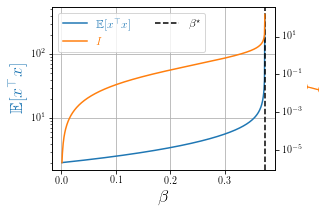

In [297]:
fig = plt.figure(figsize=(4, 3))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

p1, = ax1.plot(betas, Ex_sq, label=r'$\mathbb{E}[x^\top x]$', color='tab:blue')
p2, = ax2.plot(betas, I_values, label=r'$I$', color='tab:orange')
p3 = ax1.axvline(x=beta_max, label=r'$\beta^\star$', linestyle='--', color='k')
#leg = fig.legend()


lns = [p1, p2, p3]
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, loc='upper left', fontsize=12, ncol=2)

ax1.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

ax2.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

ax1.set_xlabel(r'$\beta$', fontsize=18)
ax1.set_ylabel(r'$\mathbb{E}[x^\top x]$', fontsize=18)
ax2.set_ylabel(r'$I$', fontsize=18)
ax1.grid(True)
#ax2.grid(True)
ax2.set_yscale('log')
ax1.set_yscale('log')
#plt.show()
plt.savefig("attack_asymptotics.pdf",bbox_inches="tight")


## Attack statistics

In [298]:
betas = [0.1, 0.25, 0.35]
T = 50
N = 3000
atk_time = 25
t = np.arange(51)

data = {beta: {} for beta in betas}

for idx, beta in enumerate(betas):
    print(beta)
    Kbar, V = compute_attack(original_system, beta)
    attacked_system = System(A, B, K, Kbar, V, np.zeros(m), Q)
    x, u, llr, cusum = simulate(N=N, T=T, sys=attacked_system, attack_time=atk_time)
    
    data[beta]['x'] = x
    data[beta]['u'] = u
    data[beta]['llr'] = llr
    data[beta]['cusum'] = cusum
 

0.1
0.25
0.35


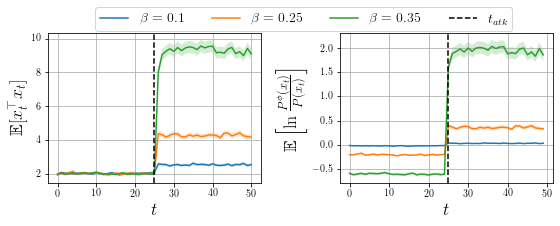

In [299]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

lns = []

for idx, beta in enumerate(betas):
    Kbar, V = compute_attack(original_system, beta)
    attacked_system = System(A, B, K, Kbar, V, np.zeros(m), Q)
    x, u, llr, cusum = data[beta]['x'], data[beta]['u'], data[beta]['llr'], data[beta]['cusum']
    
    xsq = np.linalg.norm(x,2, axis=2)**2
    xsq_mean = xsq.mean(axis=0)
    xsq_ci = (1.95 / np.sqrt(N)) * xsq.std(axis=0)
    
    llr_mean = llr.mean(axis=0)
    llr_ci = (1.95 / np.sqrt(N)) * llr.std(axis=0)
    cusum_mean = cusum.mean(axis=0)
    cusum_ci = (1.95 / np.sqrt(N)) * cusum.std(axis=0)
    
    
    l, = ax[0].plot(t, xsq_mean, label=r'$\beta={}$'.format(beta))
    ax[0].fill_between(t, xsq_mean - xsq_ci, xsq_mean + xsq_ci, alpha=0.2)
    lns.append(l)
    
    ax[1].plot(llr_mean, label=r'$\beta={}$'.format(beta))
    ax[1].fill_between(np.arange(T), llr_mean - llr_ci, llr_mean + llr_ci, alpha=0.2)
    
    #ax[2].plot(cusum_mean, label=r'$\beta={}$'.format(beta))
    #ax[2].fill_between(np.arange(T+1), cusum_mean - cusum_ci, cusum_mean + cusum_ci, alpha=0.2)

    
    
ax[0].grid(True)
ax[1].grid(True)
#ax[2].grid(True)
p3 = ax[0].axvline(x=atk_time, label=r'$t_{atk}$', linestyle='--', color='k')
p4 = ax[1].axvline(x=atk_time, label=r'$t_{atk}$', linestyle='--', color='k')
lns.append(p3)
ax[0].set_xlabel(r'$t$', fontsize=18)
ax[0].set_ylabel(r'$\mathbb{E}[x_t^\top x_t]$', fontsize=18)
ax[1].set_xlabel(r'$t$', fontsize=18)
ax[1].set_ylabel(r'$\mathbb{E}\left[\ln \frac{P^\phi(x_t)}{P(x_t)}\right]$', fontsize=18)
#ax[2].set_xlabel(r'$t$')
labs = [l.get_label() for l in lns]

fig.tight_layout()
ax[0].legend(lns, labs, loc='upper center', fontsize=14, bbox_to_anchor=(1.2, 1.22), ncol=4)
#plt.plot()
plt.savefig("attack_eval.pdf",bbox_inches="tight")